In [1]:
import icon_registration.networks as networks
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [6]:
import torch.nn.functional as F
from icon_registration.mermaidlite import compute_warped_image_multiNC
import torch
import random
import icon_registration as icon
import icon_registration.networks as networks

import numpy as np
import matplotlib.pyplot as plt
import itk

In [3]:
r_ds = torch.load("/playpen/tgreer/knees_test_set_hires")
#batched_ds = list(zip(*[r_ds[i::4] for i in range(2)]))


In [4]:
batched_ds = list(zip(*[r_ds[i::2] for i in range(2)]))

In [110]:

phi = icon.FunctionFromVectorField(
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3)
)
psi = icon.FunctionFromVectorField(networks.tallUNet2(dimension=3))

net = icon.TwoStepRegistration(phi, psi)

regis_net = icon.TwoStepRegistration(
    icon.DownsampleRegistration(net, 3), 
    icon.FunctionFromVectorField(networks.tallUNet2(dimension=3)))

BATCH_SIZE = 8
SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [1, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

net = icon.InverseConsistentNet(
    regis_net, 
    lambda x, y: (x - y) **2,
    3600,
)
    
net.assign_identity_map(input_shape)

trained_weights = torch.load("../training_scripts/gradICON/results/lncc_knees_only_interpolated-2/knee_aligner_resi_net15300")
regis_net.load_state_dict(trained_weights)


<All keys matched successfully>

In [111]:

net.cuda()
net.eval()
0

0

In [112]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0)# / BATCH_SIZE
def flips2(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True) / np.product(net.spacing)
    return dV.detach().cpu()
with torch.no_grad():
    dices = []
    folds_list = []
    
    filteredDV_list = []
    
    
    for x in batched_ds[:]:
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[0], x[2]
        moving_image, moving_cartilage = x[1], x[3]

        net(moving_image, fixed_image)
        phi_AB_vectorfield = net.phi_AB(net.identity_map)
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(phi_AB_vectorfield[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
        wmb = warped_moving_cartilage > .5
        fb = fixed_cartilage > .5
        intersection = wmb * fb
        d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
        print(d)
        dices.append(d)
        f = flips(phi_AB_vectorfield[:1])
        print(f)
        folds_list.append(f.item())
        f = flips(phi_AB_vectorfield[1:])
        print(f)
        folds_list.append(f.item())
        
        dV = flips2(phi_AB_vectorfield)
        
        dV = np.array(dV).flatten()
        dV = dV[dV < 0]
        filteredDV_list.append(dV)
        
    dd = torch.mean(torch.cat(dices).cpu())
    print(dd)
    ff = np.mean(folds_list)
    print(ff)

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


tensor([0.7161, 0.7325], device='cuda:0')
tensor(109, device='cuda:0')
tensor(147, device='cuda:0')
tensor([0.7331, 0.6623], device='cuda:0')
tensor(199, device='cuda:0')
tensor(54, device='cuda:0')
tensor([0.6885, 0.6489], device='cuda:0')
tensor(128, device='cuda:0')
tensor(42, device='cuda:0')
tensor([0.7755, 0.6732], device='cuda:0')
tensor(36, device='cuda:0')
tensor(100, device='cuda:0')
tensor([0.7241, 0.7657], device='cuda:0')
tensor(44, device='cuda:0')
tensor(36, device='cuda:0')
tensor([0.7095, 0.7789], device='cuda:0')
tensor(68, device='cuda:0')
tensor(83, device='cuda:0')
tensor([0.7288, 0.6303], device='cuda:0')
tensor(63, device='cuda:0')
tensor(57, device='cuda:0')
tensor([0.6719, 0.7503], device='cuda:0')
tensor(99, device='cuda:0')
tensor(102, device='cuda:0')
tensor([0.6864, 0.7253], device='cuda:0')
tensor(109, device='cuda:0')
tensor(120, device='cuda:0')
tensor([0.6277, 0.7152], device='cuda:0')
tensor(134, device='cuda:0')
tensor(108, device='cuda:0')
tensor([0.

tensor([0.6517, 0.6463], device='cuda:0')
tensor(194, device='cuda:0')
tensor(282, device='cuda:0')
tensor([0.6859, 0.7166], device='cuda:0')
tensor(125, device='cuda:0')
tensor(66, device='cuda:0')
tensor([0.7378, 0.7398], device='cuda:0')
tensor(44, device='cuda:0')
tensor(50, device='cuda:0')
tensor([0.7379, 0.7275], device='cuda:0')
tensor(146, device='cuda:0')
tensor(69, device='cuda:0')
tensor([0.6691, 0.7259], device='cuda:0')
tensor(23, device='cuda:0')
tensor(120, device='cuda:0')
tensor([0.7206, 0.7366], device='cuda:0')
tensor(100, device='cuda:0')
tensor(238, device='cuda:0')
tensor([0.7317, 0.7374], device='cuda:0')
tensor(308, device='cuda:0')
tensor(94, device='cuda:0')
tensor([0.7265, 0.7238], device='cuda:0')
tensor(93, device='cuda:0')
tensor(165, device='cuda:0')
tensor([0.6785, 0.7127], device='cuda:0')
tensor(179, device='cuda:0')
tensor(478, device='cuda:0')
tensor([0.5955, 0.7514], device='cuda:0')
tensor(59, device='cuda:0')
tensor(52, device='cuda:0')
tensor([0

0.70349264
125.65333333333334


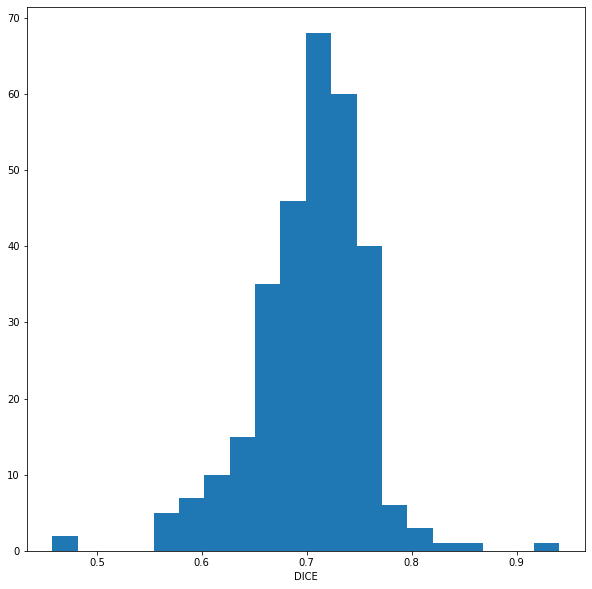

In [107]:
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
print(np.mean(dicesa))
ff = np.mean(folds_list)
print(ff)

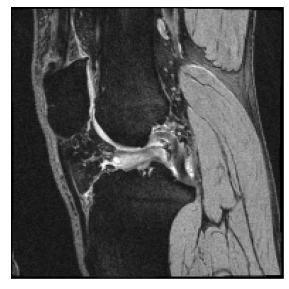

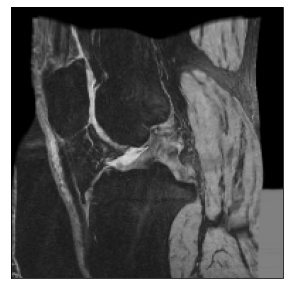

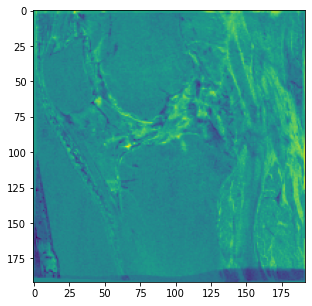

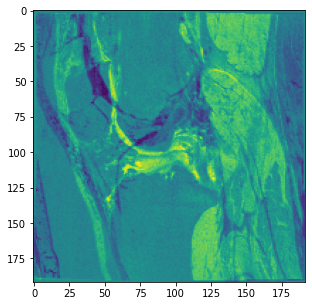

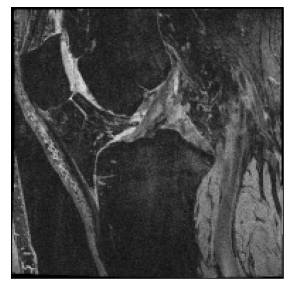

In [108]:



if not("N" in locals()):
    N = 0
N += 1
N %= 2
#N = 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (5, 5)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 40
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach() - moving_image[N, 0, slice_ ].cpu().detach())
plt.show()
#plt.imshow(net.regis_net.x_comp_phi[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
#plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

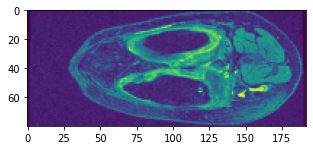

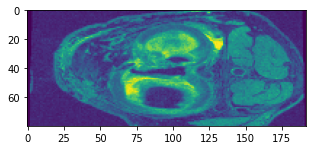

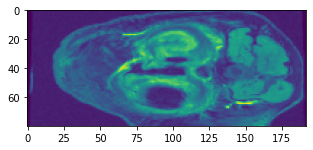

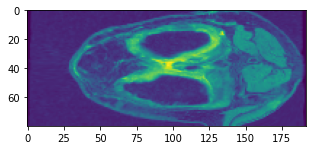

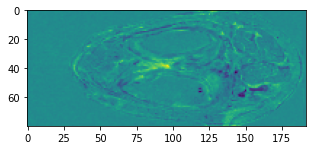

In [42]:
import matplotlib.pyplot as plt
S = 100
plt.imshow(moving_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(fixed_image[N, 0, :, S].cpu())
plt.show()
plt.imshow(net.warped_image_A[N, 0, :, S].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[N, 0, :, S].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[N, 0, :, S].cpu().detach() - moving_image[N, 0, :, S].cpu())

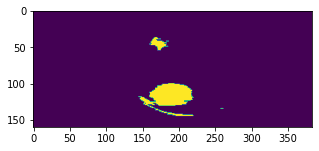

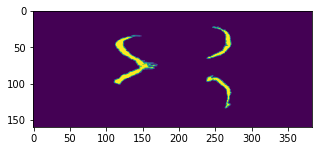

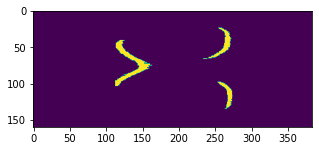

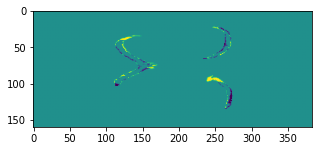

In [109]:

S = 49
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()


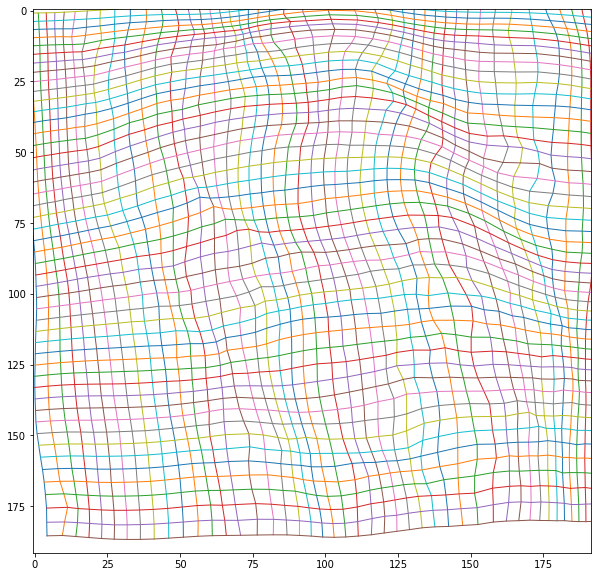

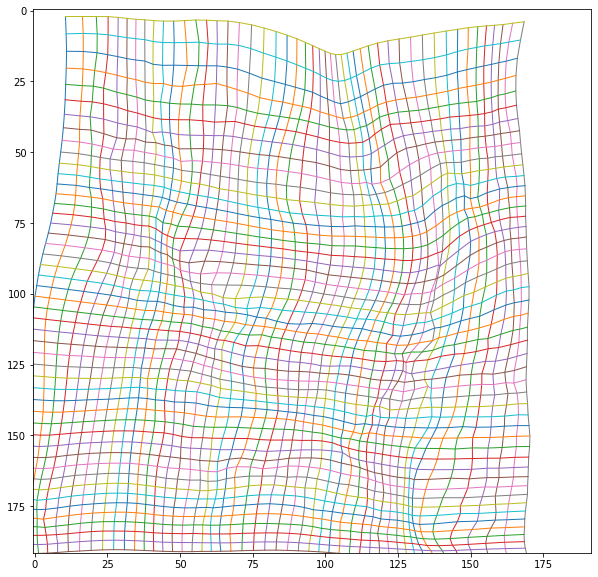

In [114]:
import icon_registration.visualize as visualize
N = (N + 1)% 2
#N = 1
plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
plt.show()
visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])


In [22]:
net.phi_AB.__closure__[0].cell_contents

<function icon_registration.network_wrappers.TwoStepRegistration.forward.<locals>.<lambda>(input_)>

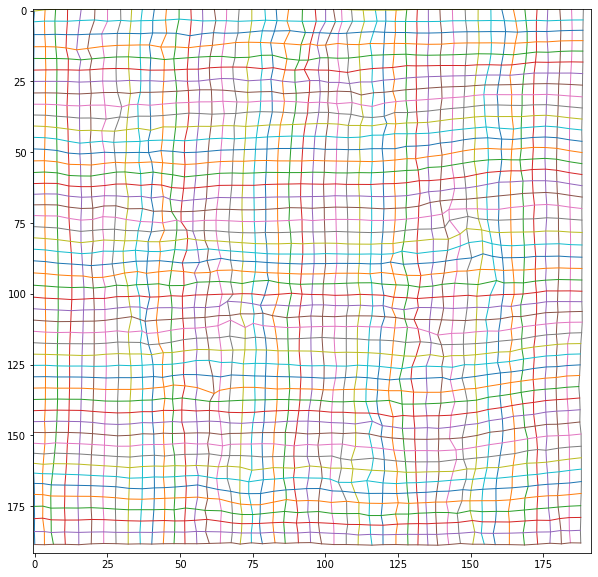

In [47]:
N = (N + 1) % 2
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identity_map))[N, [1, 2], 20])

In [25]:
import visualize
mp = hires_Net.phi_AB(hires_Net.regis_net.net.identityMap[:, :] + torch.tensor([[[[[0]]], [[[0]]], [[[0]]]]]).cuda())
visualize.show_as_grid(mp[N, [1, 2], 20])

ModuleNotFoundError: No module named 'visualize'

In [183]:
import mermaidlite

ModuleNotFoundError: No module named 'mermaidlite'

In [184]:
import visualize
mp = pretrained_lowres_net.phi_AB(hires_Net.identityMap[:, :, ::2, ::2, ::2])
visualize.show_as_grid(mp[N, [1, 2], 20])

ModuleNotFoundError: No module named 'visualize'

In [185]:
import visualize
mp = hires_Net.phi_BA(hires_Net.regis_net.net.identityMap)
visualize.show_as_grid(mp[N, [1, 2], 20])

ModuleNotFoundError: No module named 'visualize'

In [25]:
mkdir supll_regis_figures


In [59]:
import importlib
importlib.reload(visualize)
import matplotlib.colors as colors

for N in range(2):

    plt.rcParams["figure.figsize"] = (5, 5)
    def imshow(x):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
    offset = 0
    slice_ = 20
    
    for axis in ["Coronal", "Sagittal", "Axial"]:
        m_image = moving_image[N, 0].cpu().detach()
        f_image = fixed_image[N, 0].cpu().detach()
        m_warped_image_A = net.warped_image_A[N, 0].cpu().detach() 
        phi_BA = net.phi_BA_vectorfield[N]
        
        dV = flips2(net.phi_AB_vectorfield)[N, 0]
        
        if axis == "Sagittal":
            m_image_slice = m_image[slice_]
            f_image_slice = f_image[slice_]
            warped_image_A_slice = m_warped_image_A[slice_]
            phi_BA_slice = phi_BA[[1, 2], 20].clone()
            dV_slice = dV[slice_]
        if axis == "Coronal":
            m_image_slice = m_image[:, slice_].transpose(0, 1)
            f_image_slice = f_image[:, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[2, 0], :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, slice_].transpose(0, 1)
        if axis == "Axial":
            slice_ *= 2
            m_image_slice = m_image[:, :, slice_].transpose(0, 1)
            f_image_slice = f_image[:, :, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, :, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[1, 0], :, :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, :, slice_].transpose(0, 1)
            slice_ /= 2
            
            
        
        header = f"supll_regis_figures/{axis}Pair{N + offset}"
        imshow(m_image_slice)
        plt.savefig(header + "ImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(f_image_slice)
        plt.savefig(header + "ImageB.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        plt.savefig(header + "WarpedImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        visualize.show_as_grid(phi_BA_slice)
        plt.savefig(header + "WarpedImageAGrid.png", bbox_inches="tight")
        plt.clf()
        
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(dV_slice, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
        plt.title("min dV is $\\bf{" + f"{np.min(dV_slice.numpy()):.3}" + "}$ in this slice", 
                 fontdict={'fontsize':13})
        plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
        #lt.show()
        #plt.imshow(dV[1, 0, 40] < 0)


        plt.savefig(header + "dV.png", bbox_inches="tight")
        plt.clf()
    """
    imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach())
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageB.png")
    plt.clf()
    imshow(net.warped_image_B[N, 0, slice_].cpu().detach())
    visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageBGrid.png")
    plt.clf()
    """

    
    plt.show()

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [33]:
import importlib
importlib.reload(visualize)

<module 'visualize' from '/playpen-raid1/tgreer/InverseConsistency/visualize.py'>

In [26]:
plt.imshow(torch.min(dV[1, 0], axis=0).values)
plt.colorbar()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [34]:
torch.sum(dV[1] < 0)

tensor(13)

In [105]:
dV

(0,)

In [49]:
116 / (80 * 192 * 192), 1 / 25000

(3.9333767361111114e-05, 4e-05)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

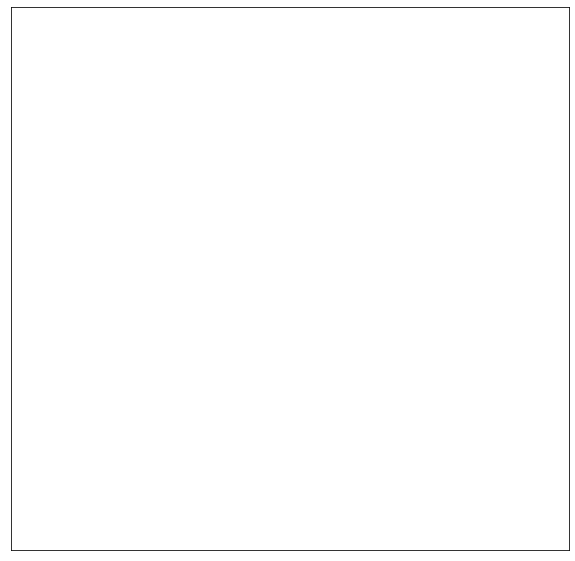

In [104]:
import matplotlib.colors as colors

plt.xticks([])
plt.yticks([])
query = dV[0, 0, 43]
plt.imshow(query, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
plt.title("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice", 
         fontdict={'fontsize':13})
plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
#lt.show()
#plt.imshow(dV[1, 0, 40] < 0)


plt.savefig("dVslice0.pdf", bbox_inches="tight")


In [97]:
2 * np.sum(folds_list) / (np.product(list(dV.shape)) * len(r_ds))

2.046440866760003e-05

In [37]:
print("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice")
from matplotlib import rc
rc('text', usetex=False)
np.min(query.numpy())

dV attains a minimum of $\bf{0.0613}$ in this slice


0.061257

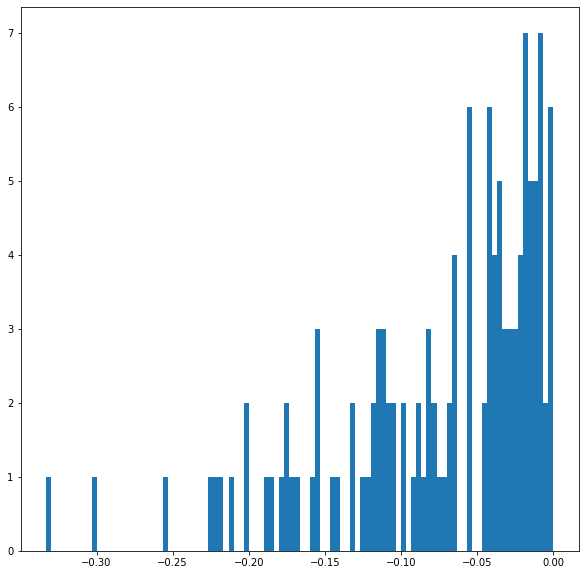

In [24]:
adv = np.array(dV)
filteredDV = adv[adv < 0.05]
plt.hist(filteredDV, bins=100)
plt.show()

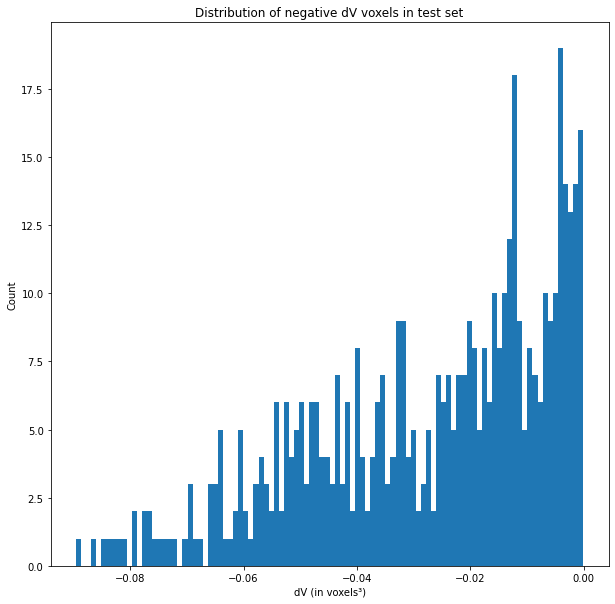

In [30]:
plt.hist(np.concatenate(filteredDV_list), bins=100)
plt.title("Distribution of negative dV voxels in test set")
plt.xlabel("dV (in voxels³)")
plt.ylabel("Count")
plt.savefig("DistributionNegativeJacobian.pdf")

In [26]:
np.mean(np.concatenate(filteredDV_list))

-0.09664285

In [27]:
np.median(np.concatenate(filteredDV_list))

-0.054298144

In [29]:
np.percentile(np.concatenate(filteredDV_list), 1)

-0.6120650005340577

In [31]:
%time net.regis_net(moving_image, fixed_image)

CPU times: user 8.3 ms, sys: 20.2 ms, total: 28.5 ms
Wall time: 21.4 ms


<function icon_registration.network_wrappers.DoubleNet.forward.<locals>.<lambda>(input_)>

In [6]:

with torch.no_grad():
    x = batched_ds[0]
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    

In [29]:
%%time
with torch.no_grad():
    phi = net.regis_net(moving_image, fixed_image)
    phi_AB_vectorfield = phi(net.identityMap).cpu()

CPU times: user 1.45 s, sys: 61 ms, total: 1.51 s
Wall time: 1.48 s


In [13]:
%%time 
net(moving_image, fixed_image)

CPU times: user 2.78 s, sys: 1.12 s, total: 3.9 s
Wall time: 3.83 s


(tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(5.5865e-05, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(6.9831e-06, device='cuda:0', grad_fn=<MeanBackward0>))

(array([ 3.,  1.,  1.,  2.,  5.,  6.,  7., 10., 17., 22., 21., 26., 30.,
        40., 41., 29., 20.,  8.,  4.,  4.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.45836532, 0.47490254, 0.4914398 , 0.507977  , 0.52451426,
        0.54105145, 0.5575887 , 0.5741259 , 0.59066314, 0.6072004 ,
        0.6237376 , 0.6402748 , 0.6568121 , 0.67334926, 0.6898865 ,
        0.70642376, 0.72296095, 0.7394982 , 0.7560354 , 0.77257264,
        0.7891099 , 0.8056471 , 0.8221843 , 0.8387216 , 0.85525876,
        0.871796  , 0.8883332 , 0.90487045, 0.9214077 , 0.9379449 ,
        0.95448214], dtype=float32),
 <BarContainer object of 30 artists>)

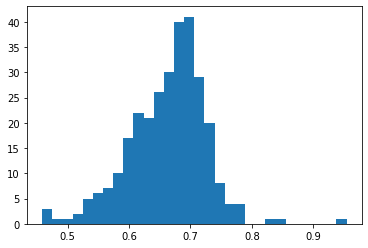

In [27]:
plt.hist(torch.cat(dices).cpu().detach().numpy(), bins=30)

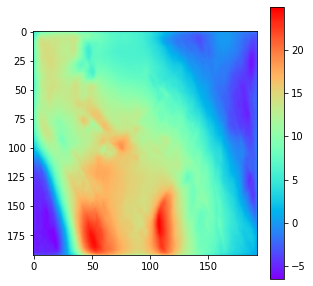

In [29]:
pixel_displacement = ((net.phi_AB_vectorfield.cpu() - net.identityMap.cpu()) 
    * torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None])
plt.imshow(pixel_displacement[0, 2, 40], cmap="rainbow")
plt.colorbar()

In [133]:
torch.max(torch.abs(pixel_displacement))

tensor(30.6417)

In [145]:
error = (net.phi_AB(net.phi_BA_vectorfield) - net.identityMap).cpu()* torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None]

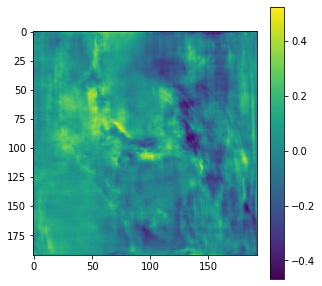

In [146]:
plt.imshow((error)[0, 0, 40])
plt.colorbar()

In [148]:
torch.sqrt(torch.mean(error**2))

tensor(0.3200)

In [173]:
plt.rcParams["figure.figsize"]

[6.4, 4.8]

Text(0, 0.5, 'number of image pairs')

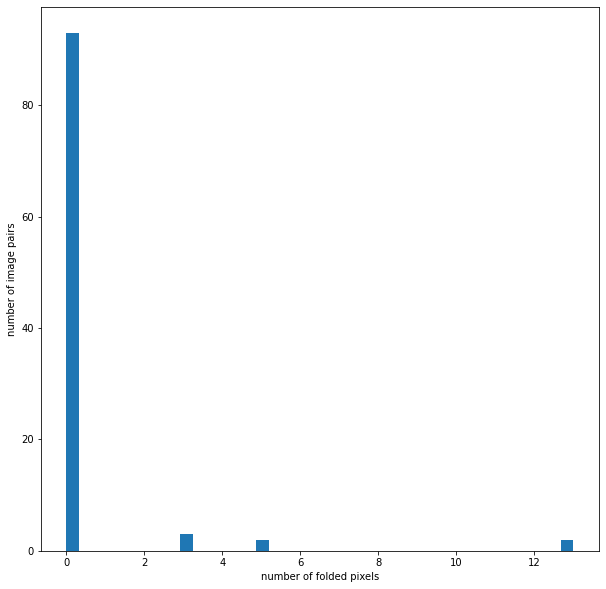

In [71]:
plt.hist(folds_list, bins=40)
plt.xlabel("number of folded pixels")
plt.ylabel("number of image pairs")

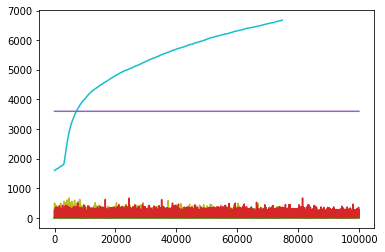

In [11]:


import pickle
with open("../results/grad_hires-1/loss_curve", "rb") as f:
    ncurve2 = pickle.load(f)
ncurve2 = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in ncurve2]
ncurve2 = np.array(ncurve2)
plt.plot(ncurve2)


import pickle
with open("../../masked_similarity_InvCon/results/hires_smart_6/loss_curve", "rb") as f:
    curve = pickle.load(f)
curve = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in curve]
curve = np.array(curve)
plt.plot(curve)


import pickle
with open("../../masked_similarity_InvCon/results/fourth_net_frozen/loss_curve", "rb") as f:
    curve4 = pickle.load(f)
curve4 = [[a, b, c, torch.mean(d).item(), e] for (a, b, c, d, e) in curve4]
curve4 = np.array(curve4)
plt.plot(curve4)

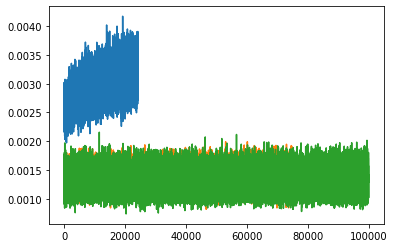

In [12]:


plt.plot(ncurve2[:, 2])

plt.plot(curve[:, 2])

plt.plot(curve4[:, 2])



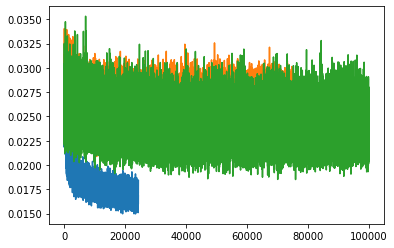

In [13]:


plt.plot(ncurve2[:, 1])


plt.plot(curve[:, 1])

plt.plot(curve4[:, 1])



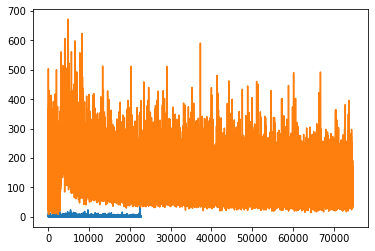

In [17]:


plt.plot(ncurve2[:, 3])


plt.plot(curve[:, 3])